# HumanEval Performance Analysis

This notebook analyzes the performance results from running HumanEval problems with and without monitoring.


In [1]:
import json
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Load the results
results_file = Path('humaneval_performance_results.json')
if not results_file.exists():
    print("Results file not found. Make sure to run run.py first!")
else:
    with open(results_file) as f:
        results = json.load(f)
    print(f"Loaded {len(results)} results")


Loaded 164 results


For each problem (164), we run without monitoring, with function level, and line level. 
Each problem is defined as as a function with a set of test case. We monitor the function itself.

For each measure we get the following values:

- problem index
- version : reference, monitored_line, monitored_function
- wall_time : the wall time to launch python interpreter and run all test case on the function
- user_time+system_time : time in the user space or sys space (user vs OS time)
- problem_time : the average time to resolve one test case. 0 in reference case
- success : if the problem passed all test
- max_memory_kb : memory used by the python process to execute
- db_size_bytes : memory of the trace db

In [2]:
# Process the results into a DataFrame
processed_data = []

for result in results:
    if 'error' in result:
        continue

    problem_idx = result['problem_index']

    # Reference data
    if 'reference' in result and 'error' not in result['reference']:
        ref_data = result['reference']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'reference',
            'wall_time': ref_data.get('wall_time', 0),
            'user_time': ref_data.get('user_time', 0),
            'problem_time': sum(ref_data.get('internal_time', []))/len(ref_data.get('internal_time', [])) / 1e9 if ref_data.get('internal_time', []) else 0,
            'system_time': ref_data.get('system_time', 0),
            'max_memory_kb': ref_data.get('max_memory_kb', 0),
            'success': ref_data.get('success', False),
            'db_size_bytes': 0  # No database for reference
        })

    # Monitored data
    if 'monitored_line' in result and 'error' not in result['monitored_line']:
        mon_data = result['monitored_line']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'monitored_line',
            'wall_time': mon_data.get('wall_time', 0),
            'user_time': mon_data.get('user_time', 0),
            'system_time': mon_data.get('system_time', 0),
            'problem_time': sum(mon_data.get('internal_time', []))/len(mon_data.get('internal_time', [])) / 1e9 if mon_data.get('internal_time', []) else 0,
            'max_memory_kb': mon_data.get('max_memory_kb', 0),
            'success': mon_data.get('success', False),
            'db_size_bytes': mon_data.get('db_size_bytes', 0)
        })

    if 'monitored_function' in result and 'error' not in result['monitored_function']:
        mon_data = result['monitored_function']
        processed_data.append({
            'problem_index': problem_idx,
            'version': 'monitored_function',
            'wall_time': mon_data.get('wall_time', 0),
            'user_time': mon_data.get('user_time', 0),
            'system_time': mon_data.get('system_time', 0),
            'problem_time': sum(mon_data.get('internal_time', []))/len(mon_data.get('internal_time', [])) / 1e9 if mon_data.get('internal_time', []) else 0,
            'max_memory_kb': mon_data.get('max_memory_kb', 0),
            'success': mon_data.get('success', False),
            'db_size_bytes': mon_data.get('db_size_bytes', 0)
        })

df = pd.DataFrame(processed_data)
print(f"Processed {len(df)} data points")
print(f"Success rate - Reference: {df[df['version'] == 'reference']['success'].mean():.2%}")
print(f"Success rate - Monitored: {df[df['version'] == 'monitored_line']['success'].mean():.2%}")
print(f"Success rate - Monitored Function: {df[df['version'] == 'monitored_function']['success'].mean():.2%}")

# Show basic statistics
df

Processed 492 data points
Success rate - Reference: 99.39%
Success rate - Monitored: 81.71%
Success rate - Monitored Function: 99.39%


,problem_index,version,wall_time,user_time,problem_time,system_time,max_memory_kb,success,db_size_bytes
0,0,reference,0.349742,0.193135,7.471789e-07,0.011719,39256,True,0
1,0,monitored_line,43.999865,21.038130,4.259570e-02,0.126314,49736,True,0
2,0,monitored_function,7.010956,3.803006,5.474772e-03,0.095879,0,True,0
3,1,reference,0.241947,0.181648,4.617011e-06,0.016626,0,True,0
4,1,monitored_line,83.608711,40.995771,9.445177e-01,0.084893,0,True,0
...,...,...,...,...,...,...,...,...,...
487,162,monitored_line,31.846050,13.833646,3.017717e-02,0.208711,0,True,0
488,162,monitored_function,11.152299,4.981730,9.483498e-03,0.099985,0,True,0
489,163,reference,0.295613,0.184900,4.427170e-07,0.012966,0,True,0
490,163,monitored_line,9.892342,4.376187,8.245386e-03,0.101405,0,True,0


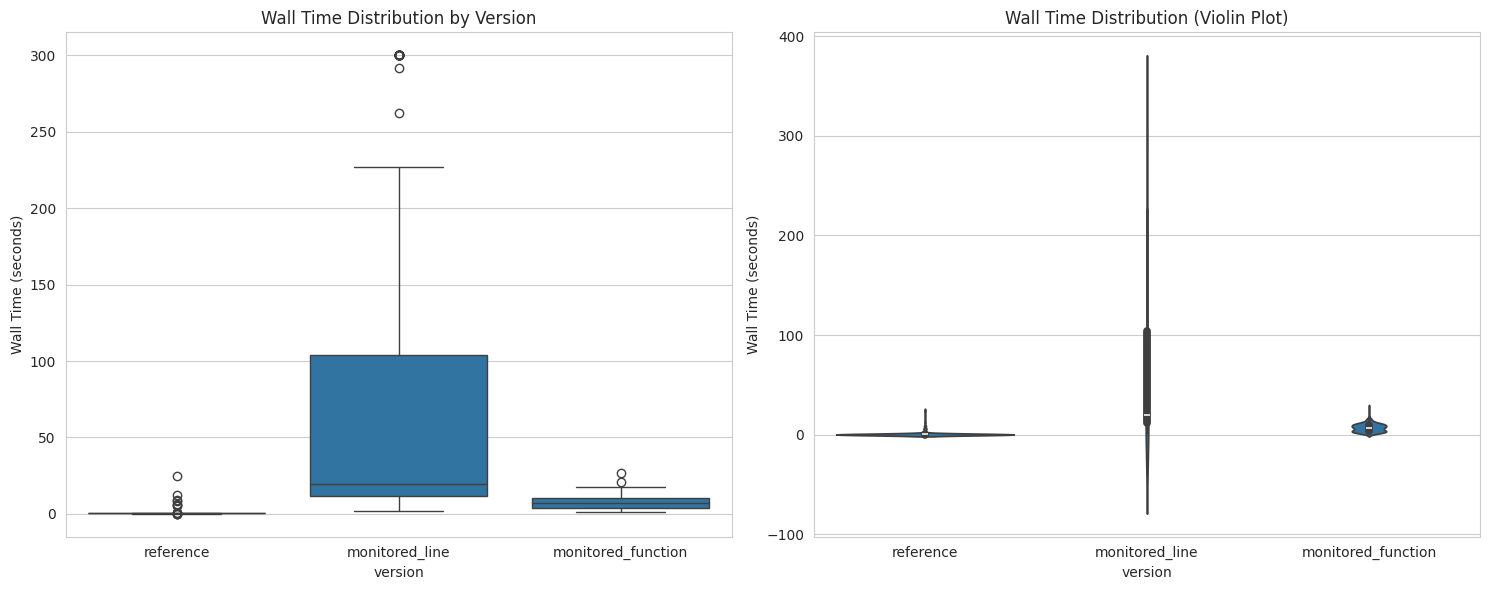

In [3]:
# Plot 1: Wall Time Comparison
plt.figure(figsize=(15, 6))

# Box plot
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution by Version')
plt.ylabel('Wall Time (seconds)')

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='version', y='wall_time')
plt.title('Wall Time Distribution (Violin Plot)')
plt.ylabel('Wall Time (seconds)')


plt.tight_layout()
plt.show()


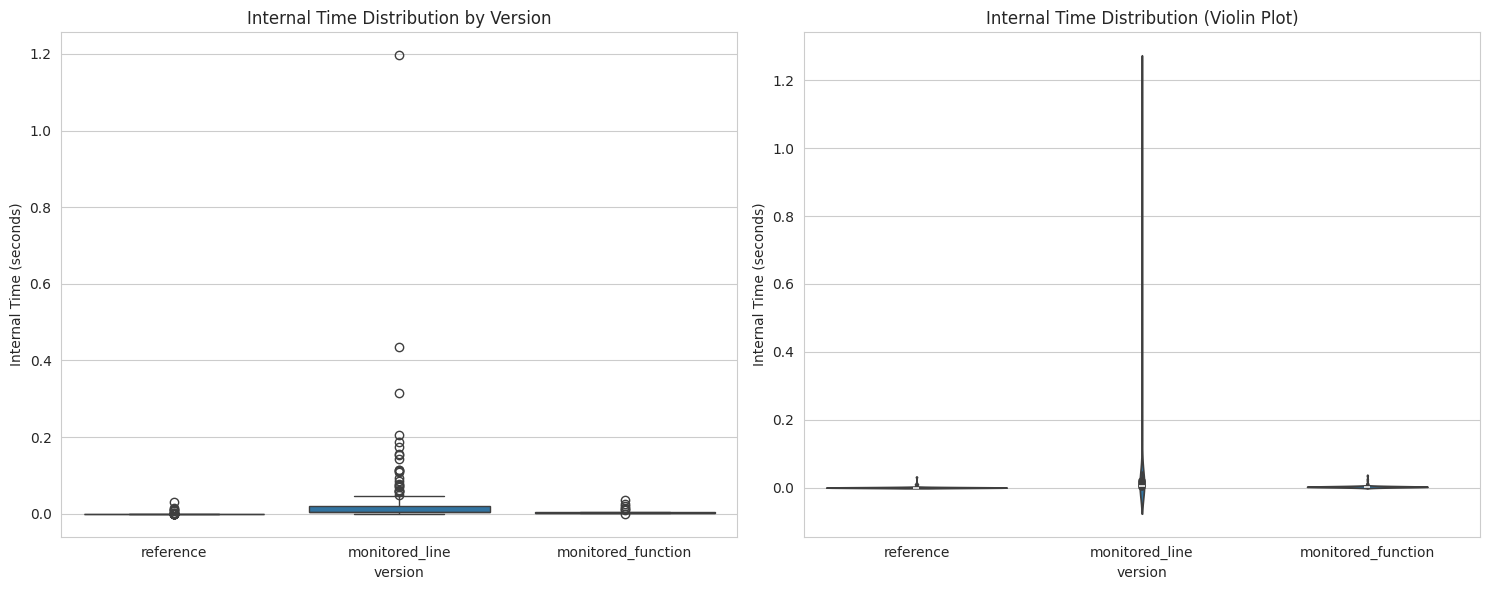

In [4]:
# Intenral time
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='version', y='problem_time')
plt.title('Internal Time Distribution by Version')
plt.ylabel('Internal Time (seconds)')

# Violin plot
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='version', y='problem_time')
plt.title('Internal Time Distribution (Violin Plot)')
plt.ylabel('Internal Time (seconds)')

plt.tight_layout()
plt.show()

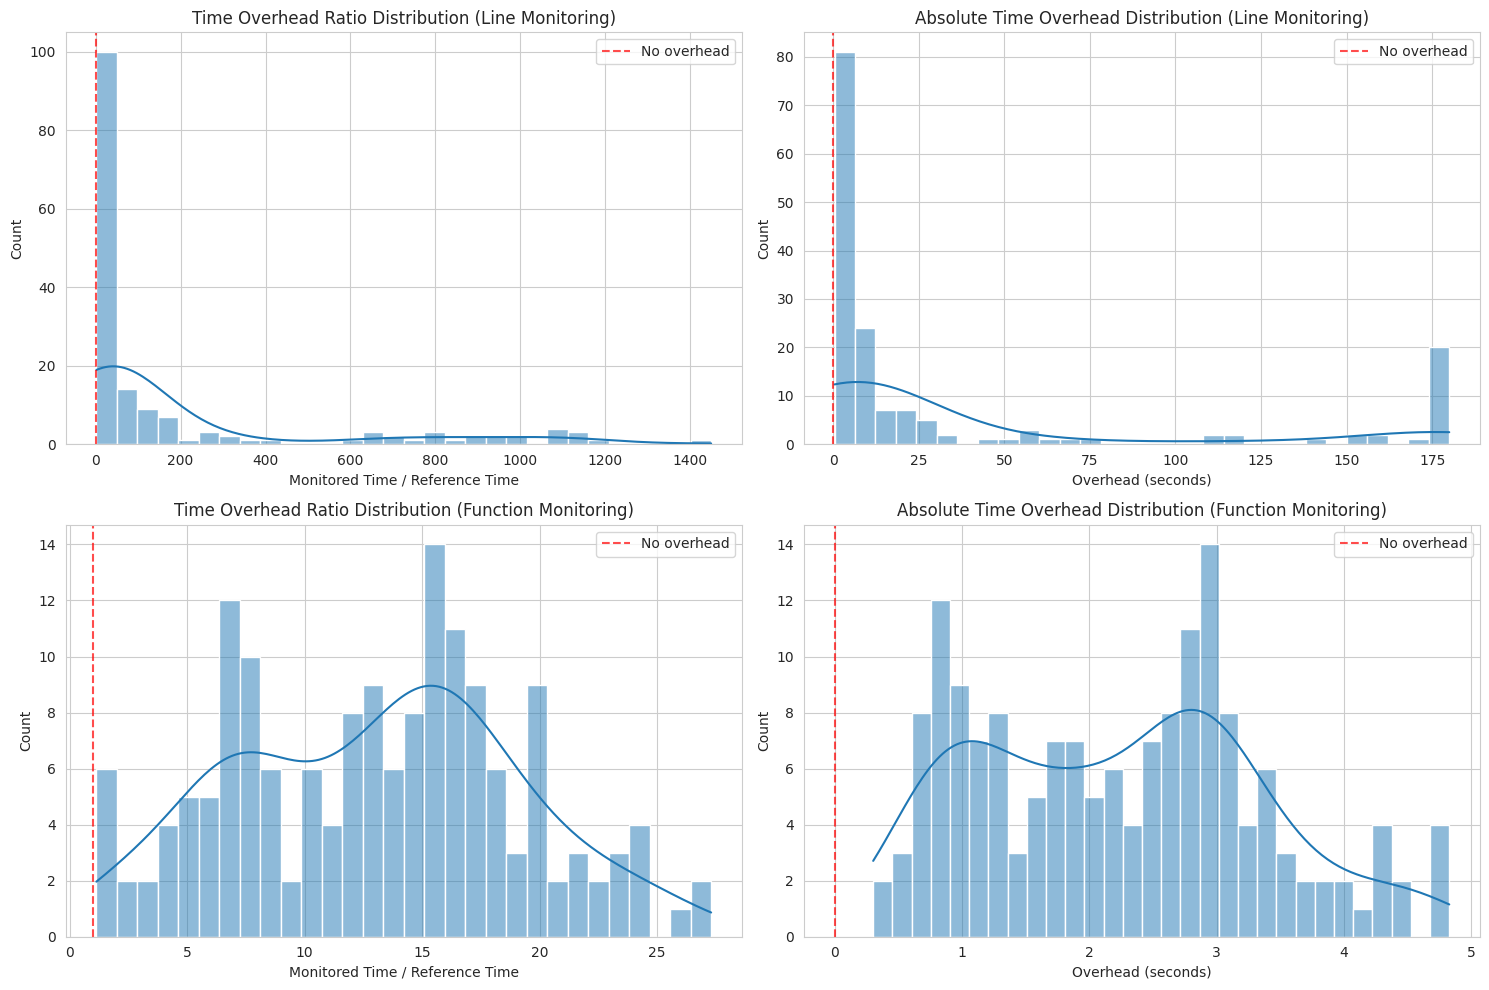

In [6]:
# Plot 3: Performance Overhead Analysis
plt.figure(figsize=(15, 10))

# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='wall_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio_line'] = pivot_time['monitored_line'] / pivot_time['reference']
pivot_time['overhead_absolute_line'] = pivot_time['monitored_line'] - pivot_time['reference']
pivot_time['overhead_ratio_function'] = pivot_time['monitored_function'] / pivot_time['reference']
pivot_time['overhead_absolute_function'] = pivot_time['monitored_function'] - pivot_time['reference']

# Overhead ratio distribution
plt.subplot(2, 2, 1)
sns.histplot(pivot_time['overhead_ratio_line'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution (Line Monitoring)')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 2)
sns.histplot(pivot_time['overhead_absolute_line'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution (Line Monitoring)')
plt.xlabel('Overhead (seconds)')
plt.legend()

# Overhead ratio distribution
plt.subplot(2, 2, 3)
sns.histplot(pivot_time['overhead_ratio_function'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution (Function Monitoring)')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 4)
sns.histplot(pivot_time['overhead_absolute_function'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution (Function Monitoring)')
plt.xlabel('Overhead (seconds)')
plt.legend()
plt.tight_layout()
plt.show()


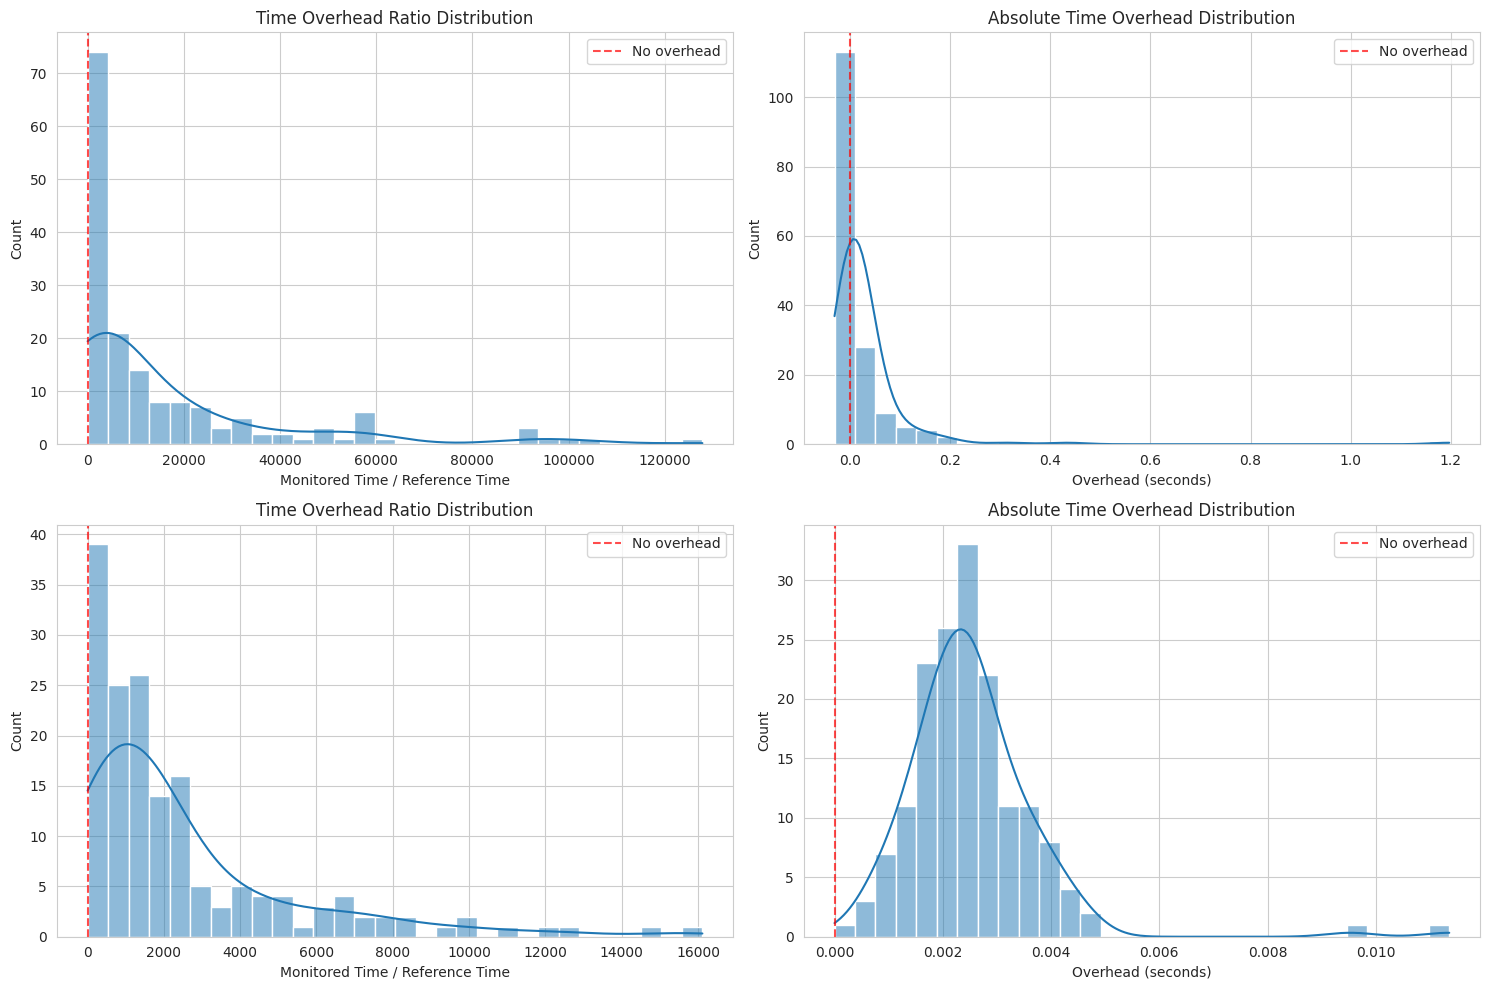

In [7]:
# Plot 3: Performance Overhead Analysis
plt.figure(figsize=(15, 10))

# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='problem_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio_line'] = pivot_time['monitored_line'] / pivot_time['reference']
pivot_time['overhead_absolute_line'] = pivot_time['monitored_line'] - pivot_time['reference']
pivot_time['overhead_ratio_function'] = pivot_time['monitored_function'] / pivot_time['reference']
pivot_time['overhead_absolute_function'] = pivot_time['monitored_function'] - pivot_time['reference']

# Overhead ratio distribution
plt.subplot(2, 2, 1)
sns.histplot(pivot_time['overhead_ratio_line'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 2)
sns.histplot(pivot_time['overhead_absolute_line'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()

# Overhead ratio distribution
plt.subplot(2, 2, 3)
sns.histplot(pivot_time['overhead_ratio_function'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()

# Absolute overhead
plt.subplot(2, 2, 4)
sns.histplot(pivot_time['overhead_absolute_function'], bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Absolute Time Overhead Distribution')
plt.xlabel('Overhead (seconds)')
plt.legend()
plt.tight_layout()
plt.show()


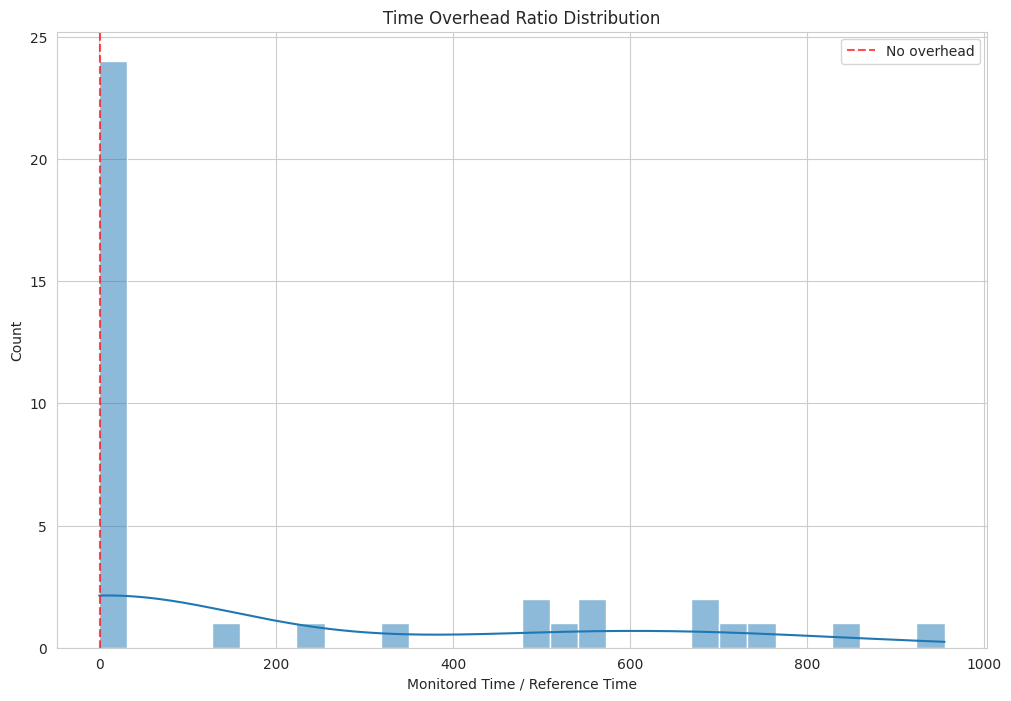

In [8]:
# Same as before, but remove outliers
# Calculate overhead for successful runs
pivot_time = df.pivot(index='problem_index', columns='version', values='problem_time')
pivot_time = pivot_time.dropna()
pivot_time['overhead_ratio'] = pivot_time['monitored_line'] / pivot_time['reference']

pivot_time = pivot_time[pivot_time['overhead_ratio'] < 1000]
sns.histplot(pivot_time['overhead_ratio'], bins=30, kde=True)
plt.axvline(x=1, color='red', linestyle='--', alpha=0.7, label='No overhead')
plt.title('Time Overhead Ratio Distribution')
plt.xlabel('Monitored Time / Reference Time')
plt.legend()
